# Clustering and Topic Models 

Name: Darshan Rajesh Tina

Andrew ID: dtina

## Clustering emails using Gaussian Mixture Models 

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). Data is provided in the `enron` data directory, with one file per email. The data set includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam. 

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents 

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the makeWordList function, construct a list of processed documents.

In [121]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [122]:
import glob
document_list = glob.glob('./data/enron/*.txt')#accessing all files with extension .txt
contentlist = []
for i in document_list:
    contentlist.append(makeWordList(i))

In [123]:
# Printing out the length
len(contentlist)

5171

### Part B: Construct a document matrix 

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [125]:
vectorizer = TfidfVectorizer(min_df=50,stop_words="english",max_df=0.8)

In [126]:
#Creating document matrix X
X = vectorizer.fit_transform(contentlist)

In [127]:
vocab = vectorizer.vocabulary_
print('The number of unique words in the vocabulary is',len(vocab))
# To ensure it is unique 
print('Confirmed length ',len(set(vocab)))

The number of unique words in the vocabulary is 1680
Confirmed length  1680


### Part C: Perform Clustering 

Perform clustering on the document matrix X using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [128]:
from sklearn.mixture import GaussianMixture
 
gmm = GaussianMixture(n_components=3,random_state=0)
test = gmm.fit(X.toarray())

In [129]:
#Means
gmm.means_

array([[0.009055  , 0.00194961, 0.00632647, ..., 0.00609533, 0.00270307,
        0.00457327],
       [0.00026757, 0.00135847, 0.00354344, ..., 0.00021224, 0.00109585,
        0.0011375 ],
       [0.00148353, 0.00207922, 0.0042846 , ..., 0.0020467 , 0.0012032 ,
        0.00129205]])

In [130]:
# Number of documents attached to each cluster
gmm_clustere_assignments = gmm.predict(X.toarray())
test_result = X.toarray()[gmm_clustere_assignments==1].mean(axis=1)
test_result_zero = X.toarray()[gmm_clustere_assignments==0].mean(axis=1)
test_result_two = X.toarray()[gmm_clustere_assignments==2].mean(axis=1)


In [131]:
#Printing the length of documents assigned to each cluster
print('Length of cluster 0 is',len(test_result_zero))
print('Length of cluster 1 is',len(test_result))
print('Length of cluster 2 is',len(test_result_two))

Length of cluster 0 is 363
Length of cluster 1 is 1786
Length of cluster 2 is 3022


In [132]:
#Checking the weights associated with each cluster
gmm.weights_

array([0.07019919, 0.34538774, 0.58441307])

In [133]:
#len(X.toarray()[gmm_clustere_assignments==1])

### Part D: Characterize the clusters

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes four parameters:
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [134]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

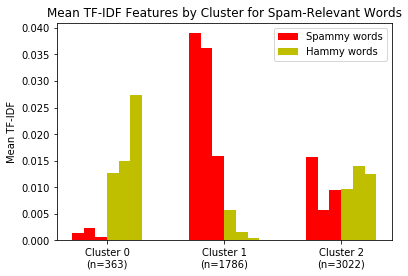

In [135]:
#Creating spam and ham indices
spam_indices=[]
spam_indices.append(vocab.get('click'))
spam_indices.append(vocab.get('www'))
spam_indices.append(vocab.get('offer'))
ham_indices = []
ham_indices.append(vocab.get('meeting'))
ham_indices.append(vocab.get('attached'))
ham_indices.append(vocab.get('review'))
#Using the given function to plot the distribution of spam and ham words in the documents
plot_spam_words_by_cluster(gmm_clustere_assignments,3,spam_indices,ham_indices)

### Part E: Interpret results [10 points]

**Based on the above observation:**
(The analysis maybe different for every time the code in the above cells are run)


Cluster 0 - Mainly corresponds to typical business emails (Ham words)
Cluster 1 - Mainly corresponds to typical spam emails (spammy words) 
CLuster 2 - A distribution between spam and ham is approximately the same


<Figure size 720x576 with 0 Axes>

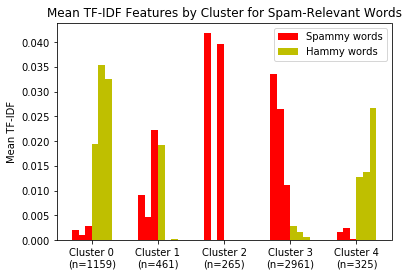

In [136]:
#Chaning the # of cluster and plotting the distribution for analysis
plt.figure(figsize=(10,8))
gmm = GaussianMixture(n_components=5,random_state=0)
test = gmm.fit(X.toarray())
gmm_clustere_assignments = gmm.predict(X.toarray())
plot_spam_words_by_cluster(gmm_clustere_assignments,5,spam_indices,ham_indices)

#### Increase in the number of clusters have given a better and a much more clear representation between the business and the spam email in each cluster
Here,
Cluster 0 - Mainly corresponds to Business emails 

Cluster 1 - Mainly corresponds to Spam emails

Cluster 2 - Corresponds to Spam emails

Cluster 3 - Mainly corresponds to Spam emails

Cluster 4 - Mainly corresponds to Businessemails

### Choice of k = 5 gives us better results than when k = 3

## Question 2: Latent "Purposes" in Mobile Apps


Thinking of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data 

In [138]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [139]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [140]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" 

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [141]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.as_matrix()
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM

C:\Users\Darshan\Miniconda3\envs\uda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


### Part C: Downweight "stop-words" 

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [142]:
from sklearn.feature_extraction.text import TfidfTransformer

In [143]:
tf_transform = TfidfTransformer()

In [144]:
#Document matrix
X = tf_transform.fit_transform(X)

In [145]:
X.shape

(180295, 173)

### Part D: Discover 10 "topics" 

   * Using the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).

In [205]:
%%time
num_topics = 10
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics,learning_method='online',random_state=0,n_jobs=-1,max_iter=10)
lda.fit(X)

Wall time: 7min 54s


In [206]:
# 10 topics 173 permissions
lda.components_.shape

(10, 173)

In [207]:
# Finding how closely a word is related to a topic
topic_word_dist = np.array(np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_]))

In [208]:
topic_word_dist.shape

(10, 173)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic 


In [209]:
#Printing top 10 words in each topic
num_top_words = 10

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_word_dist[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(permission_columns[word_idx], ':', topic_word_dist[topic_idx, word_idx])
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
Your location : coarse (network-based) location (D) : 0.2650113909379571
Your location : fine (GPS) location (D) : 0.24884250084831744
Network communication : full Internet access (D) : 0.15891830773683577
Network communication : view network state (S) : 0.1029139115913022
Phone calls : read phone state and identity (D) : 0.07956427969517774
Storage : modify/delete USB storage contents modify/delete SD card contents (D) : 0.06699740731042043
Hardware controls : record audio (D) : 0.0562982976974197
Your location : access extra location provider commands (S) : 0.019643429446526015
Default : permission to install a location provider (S) : 0.0013120341377633722
Services that cost you money : directly call phone numbers (D) : 3.0399298853685608e-06

[Topic 1]
Hardware controls : control vibrator (S) : 0.31773837944292915
System tools : prevent device from sleeping (D) : 0.3053194283998832
Network c


##### Topic 1 -> Majority of the top words are related to network so we can say that this deals with an app that mainly based on network/communication

##### Topic 2 -> Storage : modify/delete USB storage contents modify/delete SD card contents (D) : 0.7293331431492348 . Deals with storing a lot of information

##### Topic 3 -> App that starts on boot and majorly deals with reading contact information 

##### Topic 4 -> System tools : set wallpaper (S) : 0.748538 (Setting the wallpaper

##### Topic 5 -> Network communication : full Internet access (D) : 0.6748499787624138 Deals with internet and communication
            
##### Topic 6 -> Check the state of the running applications and possibly store some information related to it
##### Topic 7 -> Phone Calls and communication
##### Topic 8 -> Camera maybe possibly dealing with pictures and videos
##### Topic 9 -> Payment related application


### Part F: For each topic, listing the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic 

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings helps.

In [210]:
topic_word_dist.shape

(10, 173)

In [211]:
from operator import itemgetter

In [212]:
apps = dict(zip(app_names,app_ratings))
sorted_apps = sorted(apps.items(),key=itemgetter(1),reverse=True)

In [213]:
X.shape

(180295, 173)

In [204]:
###
lda.components_[]

(10, 173)

In [220]:
#Filtering the app names
filtered = [app_names[i] for i in range(len(app_names)) if app_ratings[i]>100000]
filtered_rating = [app_ratings[i] for i in range(len(app_ratings)) if app_ratings[i]>100000]

In [221]:
#Filtering the document matrix
Y = X[app_ratings>100000,:]
Y.T.shape
lda1 = LatentDirichletAllocation(n_components=num_topics,learning_method='online',random_state=0,max_iter=10)
lda1.fit(Y.T)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [222]:
lda1.components_.shape

(10, 95)

In [294]:
topic_app_dist = np.array(np.array([topic_app_pseudocounts / np.sum(topic_app_pseudocounts)
                                     for topic_app_pseudocounts in lda1.components_]))

In [295]:
#Printing top 3 apps with ratings greater than 100000
num_top_apps = 3

print('Displaying the top %d apps per topic and their probability within the topic...' % num_top_apps)
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_app_dist[topic_idx])[::-1]
    for rank in range(num_top_apps):
        app_idx = sort_indices[rank]
        print(rank+1,filtered[app_idx],topic_app_dist[topic_idx,app_idx])
    print()

Displaying the top 3 apps per topic and their probability within the topic...

[Topic 0]
1 Lookout Security & Antivirus 0.057214127942121155
2 Antivirus Free 0.05529318491724246
3 Pandora?? internet radio 0.04497688352492906

[Topic 1]
1 Dictionary.com 0.023284872087233236
2 Air Control Lite 0.023240115404422817
3 Paper Toss 0.02264265439632856

[Topic 2]
1 Google Translate 0.06039547662508961
2 Tap Fish 0.05793094508544937
3 Horoscope 0.048123546607280354

[Topic 3]
1 The Weather Channel 0.011407181709433766
2 Advanced Task Killer 0.011229138794677424
3 Bubble Blast 2 0.011225516667020057

[Topic 4]
1 YouTube 0.09418424130708102
2 Yahoo! Mail 0.07289426525267302
3 WhatsApp Messenger 0.06895883781751629

[Topic 5]
1 Gmail 0.14956289478300488
2 LauncherPro 0.07196831950730181
3 ColorNote Notepad Notes 0.010100895101643654

[Topic 6]
1 Opera Mini web browser 0.07545844024742207
2 Skyfire Web Browser 4.0 0.051994952260500146
3 Dolphin Browser™ HD 0.051363857347605624

[Topic 7]
1 Handcent

In [170]:
len(sort_indices)

95

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE 


Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [277]:
X.shape

(180295, 173)

In [281]:
lda2 = LatentDirichletAllocation(n_components=10,learning_method='online',n_jobs=-1,max_iter=10,random_state=0)
dummy = lda2.fit_transform(X)

In [282]:
dummy.shape

(180295, 10)

In [280]:
#lda2.components_.shape

(10, 173)

In [296]:
topic_app_dist = np.array(np.array([topic_app_pseudocounts / np.sum(topic_app_pseudocounts)
                                     for topic_app_pseudocounts in dummy.T]))

In [297]:
v = np.vstack([topic_app_dist[i] for i in range(10)])
h = np.hstack([topic_app_dist[i] for i in range(10)])
h.shape

(1802950,)

In [298]:
topic_app_dist.shape

(10, 180295)

In [299]:
test = np.argmax(topic_app_dist,axis=0)

In [300]:
len(test)

180295

In [334]:
%%time
from sklearn.manifold import TSNE
tsne  = TSNE(n_components=2,random_state=0,learning_rate=400,angle=0.99,init='pca',perplexity=200)


Wall time: 0 ns


In [337]:
data_fitted = tsne.fit_transform(v.T[:10000,:])
data_fitted.shape

(10000, 2)

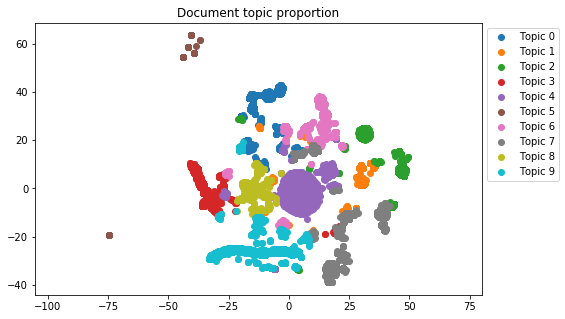

In [341]:
import seaborn as sns
palette = np.array(sns.color_palette("hls", 10))
plt.figure(figsize=(8,5))
#plt.scatter(data_fitted[test[:5000]==1,0],data_fitted[test[:5000]==1,1],cmap='Spectral')
for i in range(10):
     plt.plot(data_fitted[test[:10000]==i,0],data_fitted[test[:10000]==i,1],"o", label="Topic " + str(i))
plt.legend(bbox_to_anchor=(1,1))
plt.title('Document topic proportion')
plt.axis('equal')
plt.show()